<a href="https://colab.research.google.com/github/annoy21/protfolio/blob/main/Self_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy 
!pip install math.pi
!pip install sympy

from math import pi
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.0/473.0 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for math.pi: filename=math_pi-0.0.7-py3-none-any.whl size=2225 sha256=91f7a9366049ab4d3bbdb06e2b25c32e0d9cb1937cb8307942f8a5a0ea575fd4
  Stored in directory: /root/.cache/pip/wheels/15/9f/1b/d1ba23f63f0982418f59f7fe48cd19c66e00661dd9a0a577e5
  Created wheel for pi-1mp: filename=pi_1mp-0.0.2-py3-none-any.whl size=471964 sha256=39861c042bccfc64940be4c170509ad2b590143f14a549b7be620e109814d8a9
  Stored in directory: /root/.cache/pip/wheels/46/71/01/128cbbcf249392907e6934d6ade8883cd7ba75869d6b1b2dbd
Successfully built math.pi pi-1mp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publi

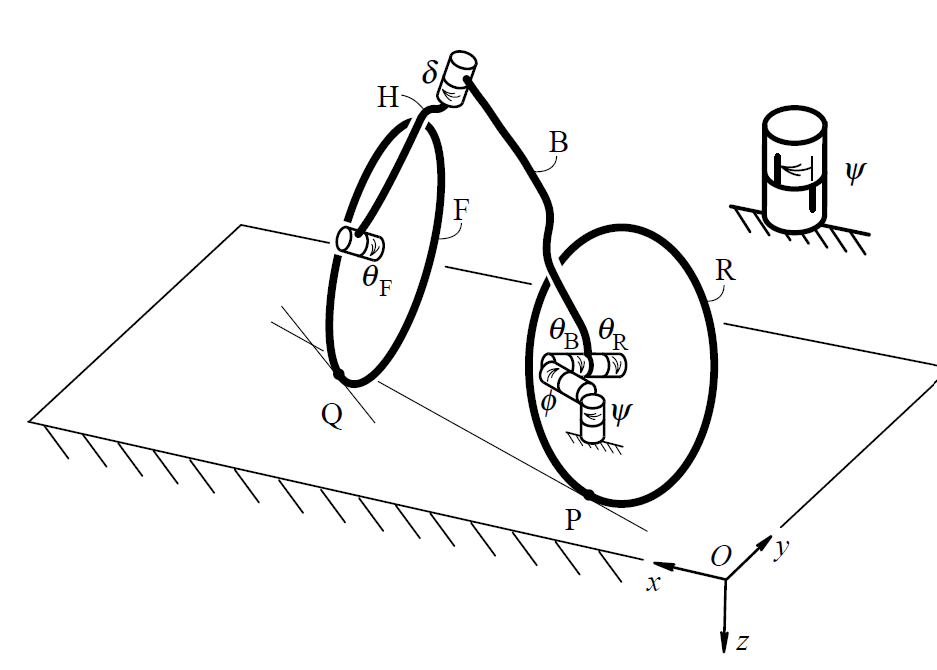

In [ ]:
# Inputs :--->

# general
w = 1.02; # wheel base in m
c = 0.08; # trail in m
radfdeg = 18*(pi/180); # 90-72
lam = (pi/10)*(radfdeg); # steer axis tilt (pi/2 - head angle)
g = 9.81; # gravity in Nm-1
v = 0; # forward speed in m/s (Could be made variable)

# Rear wheel
rr = 0.3; #Radius in m
mr = 2; # Mass in kgs
Irxx = 0.0603; #Moment of Inertia x in kg m^2
Iryy = 0.12; #Moment of Inertia y in kg m^2
MIr = [Irxx,Iryy]; #Moment of Inertia

# Body and Frame Assembly
mb = 85;  # Mass of body in Kgs
xb = 0.3; # Position center of mass x in m
zb = -0.9;  # Position center of mass z in m
comb = [xb,zb]; # Center of mass

Ibxx = 9.2; # Moment of Inertia xx in kg m^2
Ibxz = 2.4; # Moment of Inertia xz in kg m^2
Ibyy = 11; # Moment of Inertia yy in kg m^2
Ibzz = 2.8; # Moment of Inertia zz in kg m^2

MIb = np.array([[Ibxx,0,Ibxz],[0,Ibyy,0],[Ibxz,0,Ibzz]]); # Moment of Inertia of body in kg m^2

# Handle Bar and Fork Assembly
xh = 0.0; # Position center of mass x in m
zh = -0.7;  # Position center of mass z in m
comb = [xh,zh]; # Center of mass

mh = 4; # Mass in kgs

Ihxx = 0.05892; # Moment of Inertia xx in kg m^2
Ihxz = -0.00756; # Moment of Inertia xzw in kg m^2
Ihyy = 0.06; # Moment of Inertia yy in kg m^2
Ihzz = 0.00708; # Moment of Inertia zz in kg m^2

MIh = np.array([[Ihxx,0,Ihxz],[0,Ihyy,0],[Ihxz,0,Ihzz]]); # Moment of Inertia of handle bar and fork in kg m^2

# Front wheel
rf = 0.35; #Radius in m
mf = 3; # Mass in kgs
Ifxx = 0.1405; #Moment of Inertia x in kg m^2
Ifyy = 0.28; #Moment of Inertia y in kg m^2
MIf = [Ifxx,Ifyy]; #Moment of Inertia



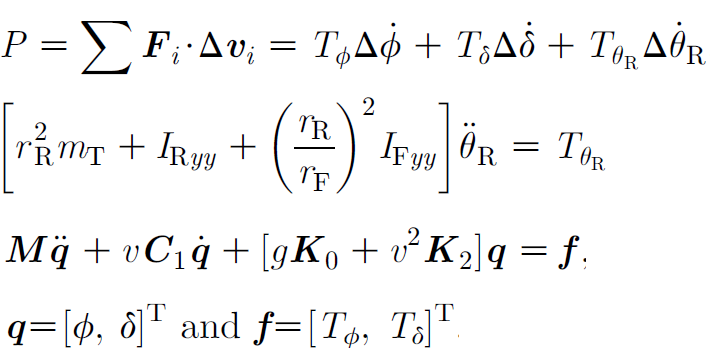

In [ ]:
# Calculations
#Moment of Inertia

mt = mr + mb + mh + mf;
xt = ((xb*mb) + (xh*mh) + (w*mf))/mt;
zt = ((-rr*mr) + (zb*mb) + (zh*mh) + (-rf*mf))/mt;


Irzz = Irxx;
Ifzz = Ifxx;
Itxx = Irxx + Ibxx + Ihxx + Ifxx + (mr*rr*rr) + (mb*zb*zb) + (mh*zh*zh) + (mf*rf*rf);
Itxz = Ibxz + Ihxz - (mb*xb*zb) - (mh*xh*zh) + (mf*w*rf);
Itzz = Irzz + Ibzz + Ihzz + Ifzz + (mb*xb*xb) + (mh*xh*xh) + (mf*w*w);  # Moment of Inertia for whole vehicle along z axis


ma = mh + mf;
xa = ((xh*mh)+(w*mf))/ma;
za = ((zh*mh)-(rf*mf))/ma;

Iaxx = Ihxx + Ifxx + (mh*(zh-za)*(zh-za)) + (mf*(rf+za)*(rf+za));
Iaxz = Ihxz - (mh*(xh-xa)*(zh-za)) + (mf*(w-xa)*(rf+za));
Iazz = Ihzz + Ifzz + (mh*(xh-xa)*(xh-xa)) + (mf*(w-xa)*(w-xa));

ua = (xa - w - c)* np.cos(lam) - za * np.sin(lam);  # perpendicular distance between steering axis and com of front assembly

Iall = (ma*(ua**2)) + (Iaxx * (np.sin(lam)**2)) + (2 * Iaxz * np.sin(lam) * np.cos(lam)) + (Iazz * (np.cos(lam)**2));
Ialx = -(ma*ua*za) + (Iaxx * np.sin(lam)) + (Iaxz * np.cos(lam));
Ialz = (ma*ua*xa) + (Iaxz * np.sin(lam)) + (Iazz * np.cos(lam));

mu = (c/w) * np.cos(lam); # Ratio of Mechanical Trail to wheel base

# Gyrostatic Coefficients

Sr = Iryy / rr ;
Sf = Ifyy / rf ;
St = Sr + Sf ;

Sa = (ma*ua) + (mu*mt*xt); #static moment term 


# Matrices

Mcc = Itxx ;
Mcd = Ialx + (mu*Itxz);
Mdc = Mcd;
Mdd = Iall + (2*mu*Ialz) + ((mu**2)*Itzz);

M = np.array([[Mcc,Mcd],[Mdc,Mdd]]);  # Symmeteric mass matrix M (constant)

Kocc = mt * zt;
Kocd = -Sa;
Kodc = Kocd;
Kodd = -Sa * np.sin(lam);

Ko = np.array([[Kocc,Kocd],[Kodc,Kodd]]); # Gravity dependent stiffness matrix Ko (Constant)

K2cc = 0;
K2cd = ((St-(mt*zt)/w)) * np.cos(lam);
K2dc = 0; 
K2dd = ((Sf + Sa*np.sin(lam)) /w) * np.cos(lam);

K2 = np.array([[K2cc, K2cd],[K2dc,K2dd]]); # Velocity Dependent Stiffness Matrix K2 (Constant)

C1cc = 0;
C1cd = mu*St + Sf * np.cos(lam) + (Itxz/w) * np.cos(lam) + mu*mt*zt;
C1dc = - (mu*St + Sf * np.cos(lam));
C1dd = (Ialz/w) * np.cos(lam) + mu * (Sa + (Itzz/w) * np.cos(lam));

C1 = np.array([[C1cc,C1cd],[C1dc,C1dd]]); # Damping Matrix (Constant)




In [ ]:
# Control Equation.

chi = 5;
thetar2dot = 4;


Tthetar = ((rr**2)*mt + Iryy + np.multiply(((rr/rf)**2),Ifyy))*thetar2dot;


vtemp2 = np.add(np.multiply(g,Ko), (np.multiply(v**2 ,K2)));
v3 = np.multiply(chi, vtemp2);


